# Metro Coverage

- TODO: Weigh-in the population density into the random point generation.

In [1]:
# a million imports
import geopandas
import geoplot
import numpy as np
import pandas as pd
import random
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import plotly.express as px
import seaborn as sns
import matplotlib as mpl
import geoplot.crs as gcrs
from bs4 import BeautifulSoup
import requests
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# define functions
# matplotlib params 
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"   
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5

# matplotlib adjustments
def default_plot(ax, spines): 
    ax = plt.gca()
    # Remove unnecessary axes and ticks (top and bottom)
    ax.spines["top"].set_visible(False)   
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    # Set the ticks facing OUTWARD
    ax.get_yaxis().set_tick_params(direction='out')
    ax.get_xaxis().set_tick_params(direction='out')
    
    # Remove grid
    #ax.grid('off')
    
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
        
    if 'right' in spines:
        ax.yaxis.set_ticks_position('right')

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')

    return ax

# generate random points within polygon (modified from a StackOverflow post)
def random_points_within(poly, num_points):
  
    # get exterior limits of the polygon
    min_x, min_y, max_x, max_y = poly.bounds

    points = []
    
    # loop until n points is reached
    while len(points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        
        # if point inside polygon
        if (random_point.within(poly)):
            points.append(random_point)

    return points

# parse URL
def response_and_soup(url):
    
    """
    Turns links into soup.
    Input: URL to scrape
    Output: the soup from BeautifulSoup package
    """
    
    # get response
    response = requests.get(url)
    print('Response code:', response.status_code)
    
    # cook soup
    soup = BeautifulSoup(response.content, "html.parser")
    
    return soup

# creating custom colorbars
def make_colorbar(data, units, cmap, filename, vmax):
    
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
    
    norm = mpl.colors.Normalize(vmin=min(data), vmax=vmax)

    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
    cb1.set_label(units)
    plt.savefig(filename)

In [3]:
# takes in as input a boundary area and points of interest (lat/lon)
# THE REGION MUST HAVE A GEOMETRY COLUMN!
# POINTS OF INTEREST MUST BE IN SHAPELY POINT COORDINATES: POINT (LAT LON)

def min_distance_random(region, poi, npoints, name):
    
    # get exterior of multipolygons
    exterior = region.unary_union
    
    # remove points outside the city
    poi = [point for point in poi if point.within(exterior)]
           
    # plot figure to see input data
    ax = geoplot.polyplot(region, figsize=(10, 10), lw= 1, facecolor= 'none', edgecolor='k', alpha=1);
    for p in poi:  
        ax.scatter(p.x, p.y, facecolor='r', edgecolor='k', s=50);
    ax.set_title('Area Boundary and Points of Interest')
    plt.tight_layout()
    plt.savefig('figures/' + name + '_points_and_region.png')
    
    # random point generation within the boundary area
    random_points = random_points_within(exterior, npoints)
    
    # showing random points generated
    ax = geoplot.polyplot(region, figsize=(10, 10), lw= 1, facecolor= 'none', edgecolor='k', alpha=1);
    for rp in random_points:  
        ax.scatter(rp.x, rp.y, facecolor='r', edgecolor=None, s=1);    
    ax.set_title('Random Points Generated')
    plt.tight_layout()
    plt.savefig('figures/' + name + '_random_points.png')
    
    # calculate distances from random point to every point of interest and grab the minimum
    distances = []
    for rp in random_points: 
        # multiply by 100000 (scale)
        distances += [min([rp.distance(p) for p in poi]) * 100000]
        
    # distance histogram    
    fig, ax = plt.subplots(figsize=(7, 5))
    ax = default_plot(ax, ['left'])
    plt.xlabel('Distance to closest POI (m)')
    plt.ylabel('Probability')
    plt.hist(distances, bins= 50, color='k', rwidth=.85, density= True);
    plt.tight_layout()
    plt.savefig('figures/' + name + '_distance_histogram.png')
        
    # plot color coded points
    # extract x and y coordinates to plot with heatmap
    x_coords = [p.x for p in random_points]
    y_coords = [p.y for p in random_points]

    plt.figure()
    ax = geoplot.polyplot(region, figsize=(10, 10), lw= 1, facecolor= 'none', edgecolor='k', alpha=1);
    ax.scatter(x_coords, y_coords, c=distances, cmap= mpl.cm.get_cmap('viridis_r'), edgecolor=None, s= 20, vmax=max(distances));
    ax.set_title('Distance to Closest Point of Interest')
    plt.tight_layout()
    plt.savefig('figures/' + name + '_distance_to_point_heatmap.png')
    
    # create the colorbar for heatmap
    make_colorbar(data=distances, units='Distance to closest station (m)', cmap= mpl.cm.get_cmap('viridis_r'), filename='figures/' + name + '_distance_to_closest_point_colorbar.png', vmax=max(distances))
    
    
    # Calculate number of stations within 1 km.    
    # This metric quantifies number of options rather than overall coverage.
    
    # generate circles with X diameter (km units)
    diameter = 1
    circles = geopandas.GeoSeries(random_points).buffer(diameter/100)
   
    # iterate over circles and count points of interest inside
    n_inside = []
    for circle in circles:
        count = 0
        for p in poi:
            if p.within(circle):
                count += 1
        n_inside += [count]
        
    # plot histogram
    fig, ax = plt.subplots(figsize=(6, 4))
    ax = default_plot(ax, ['left'])
    plt.xlabel('Probability')
    plt.ylabel('Number of points')
    plt.title('Probability of X Points (within 1km)')
    plt.hist(n_inside, bins= max(n_inside), color='k', rwidth=.9, density= True);
    plt.tight_layout()
    plt.savefig('figures/' + name + '_number_of_points_histogram.png')
        
    # plot map
    plt.figure()
    ax = geoplot.polyplot(region, figsize=(10, 10), lw= 1, facecolor= 'none', edgecolor='k', alpha=1);
    ax.scatter(x_coords, y_coords, c=n_inside, cmap= mpl.cm.get_cmap('viridis'), vmax=10, edgecolor=None, s= 25);
    ax.set_title('Number of Stations (within 1km)')
    plt.tight_layout()
    plt.savefig('figures/' + name + '_points_inside_heatmap.png')
    
    # create colorbar for heatmap
    make_colorbar(data=n_inside, units='Number of Points within (1 km)', cmap= mpl.cm.get_cmap('viridis'), filename='figures/' + name + '_points_within1_colorbar.png', vmax=10)
        
    # Percentage of area covered
    # we draw circles of defined radius around each of our points of interest
    poi_area = geopandas.GeoSeries(poi).buffer(diameter/100).unary_union
    
    # calculate difference
    difference = region['geometry'].difference(poi_area)
    
    # calculate intersection
    intersection = region['geometry'].intersection(poi_area)
    
    # calculate proportion of area covered
    area_covered = poi_area.area/region.geometry.unary_union.area
    
    # We could even calculate the percentage of each subdivision that is covered
    #regional_proportion = region.Freguesia, difference.area/region.geometry.area
    
    # plot intersection area
    ax = geoplot.polyplot(difference[~difference.is_empty], figsize=(10, 10), lw= 1, facecolor='grey', alpha=0.7)
    geoplot.polyplot(intersection[~intersection.is_empty], ax=ax, lw= 1, alpha=0.7);    
    for p in poi:  
        ax.scatter(p.x, p.y, facecolor='r', edgecolor='k', s=15);   
    plt.tight_layout()
    plt.savefig('figures/' + name + '_area_difference_map.png')
    
    return distances, n_inside, [poi_area.area, region.geometry.unary_union.area], random_points

# Lisbon Data Cleaning

In [4]:
# open data files
lisbon = geopandas.read_file('C:/Users/Zaca/Documents/Datasets/metro/lisbon/lisbon.shp').to_crs(epsg=4326)
metro_raw = pd.read_json('C:/Users/Zaca/Documents/Datasets/metro/lisbon/lisbon_subway.geojson')
metro = json_normalize(metro_raw['features'])

# save coordinates
lisbon_stations = metro['geometry.coordinates']
lisbon_stations = [Point(x, y) for x, y in lisbon_stations]

In [5]:
# clean metro data in case I need which line we are talking about
metro['properties.INF_DESCRICAO'].fillna('vermelha', inplace= True)

clean_lines = []

for s in metro['properties.INF_DESCRICAO']:
    
    line = s.lower().replace('\n', '').replace('linha', '').replace(';', '/').replace('.', '/').strip().split('/')
    
    if len(line) > 2:
        line = [line[0]]
    else:
        line = [line.strip() for line in line]
        
    clean_lines += [line]

metro['properties.INF_DESCRICAO'] = clean_lines

In [6]:
# verification of distances with google maps
restauradores = [Point(x, y) for x, y in metro[metro['properties.INF_NOME'] == 'Restauradores']['geometry.coordinates']]
saldanha = [Point(x, y) for x, y in metro[metro['properties.INF_NOME'] == 'Saldanha']['geometry.coordinates']]
google_measured = 2260
print(restauradores[0].distance(saldanha[0])*100000)

1941.22559344421


## Lisbon Data Ready

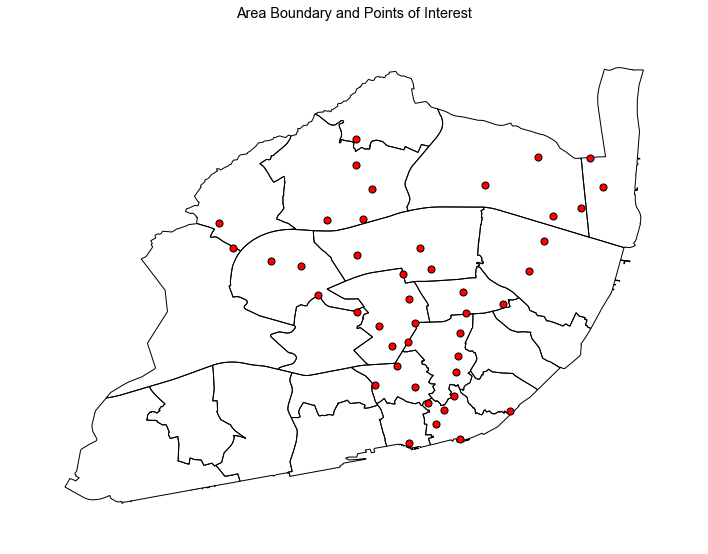

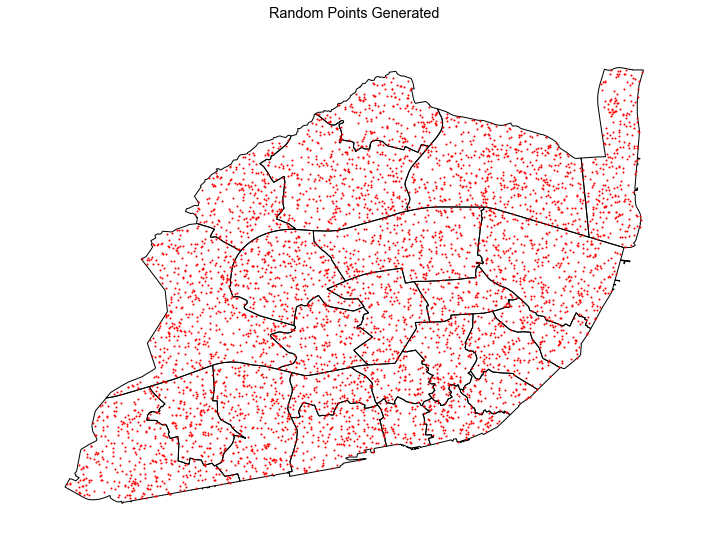

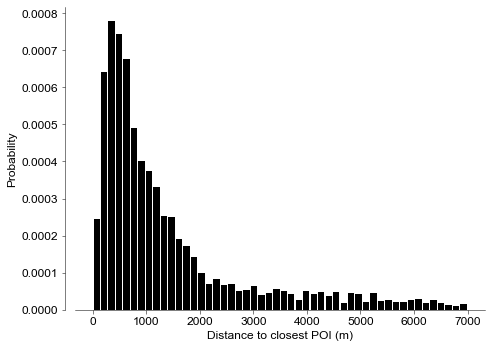

<Figure size 432x288 with 0 Axes>

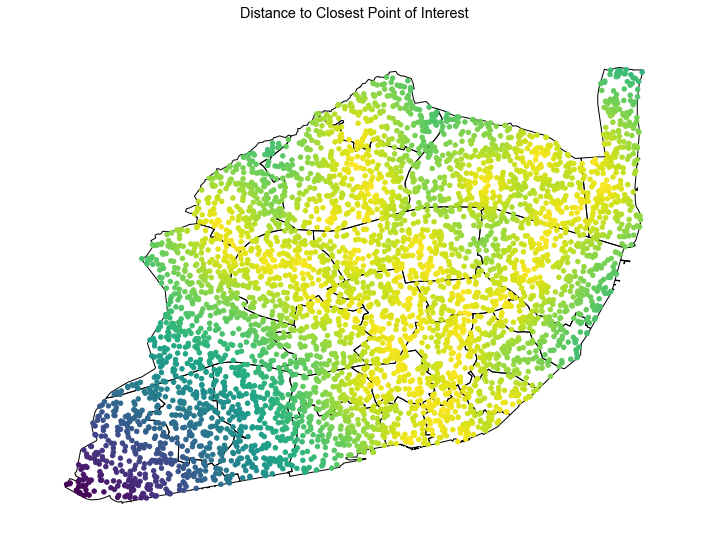

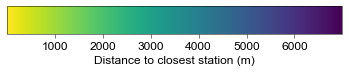

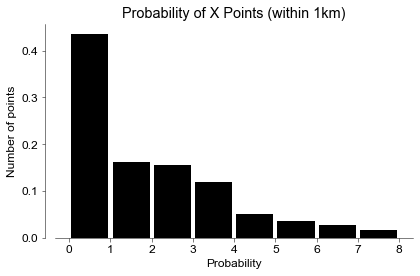

<Figure size 432x288 with 0 Axes>

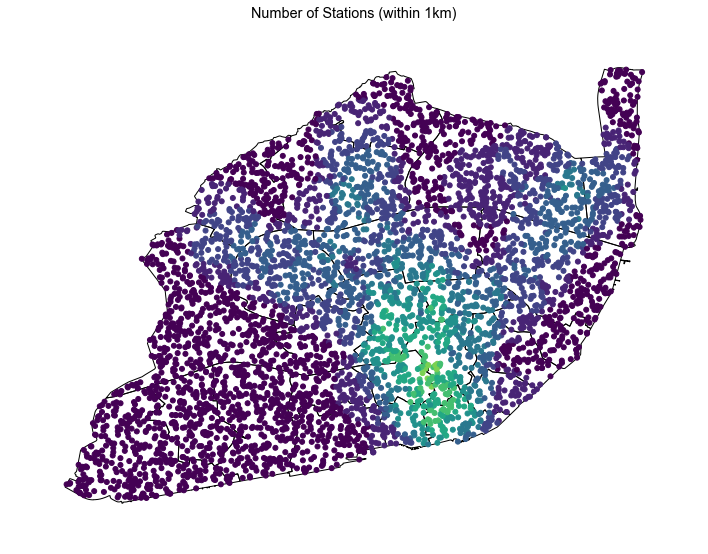

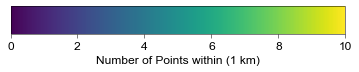

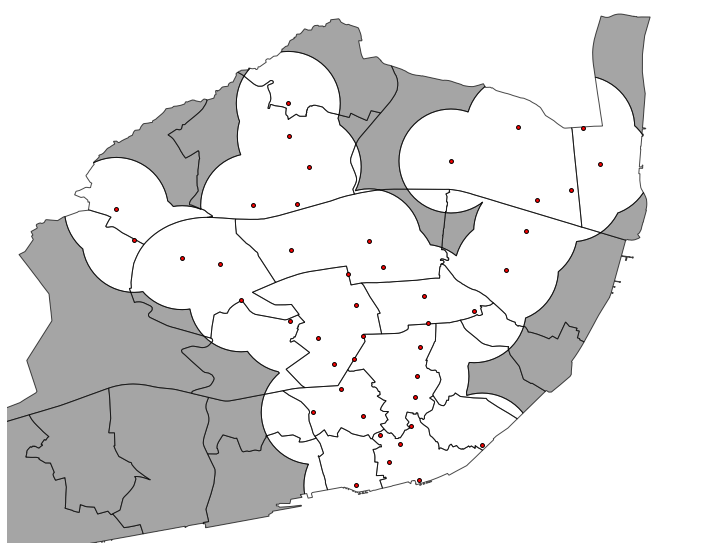

In [7]:
lisbon_distances, lisbon_n_points, lisbon_area_covered, lisbon_random = min_distance_random(lisbon, lisbon_stations, 5000, 'lisbon')

# New York City

In [8]:
# open data files
nyc = geopandas.read_file('C:/Users/Zaca/Documents/Datasets/metro/nyc/nyc.shp').to_crs(epsg=4326)
nyc_metro = pd.read_csv('C:/Users/Zaca/Documents/Datasets/metro/nyc/nyc_subway.csv')

In [9]:
# remove staten island from calculations because there is no metro there
nyc = nyc.loc[nyc['boroname'] != 'Staten Island']

In [10]:
# clean point locations
nyc_stations = nyc_metro['the_geom'].str.replace('POINT ', '').str.replace('(', '').str.replace(')', '').str.split(' ')

In [11]:
# transform from string to float
nyc_stations_float = []
    
for i in range(len(nyc_stations)):
    nyc_stations_float += [[float(x) for x in nyc_stations[i]]]

nyc_stations = [Point(x, y) for x, y in nyc_stations_float]

### NYC Data Ready

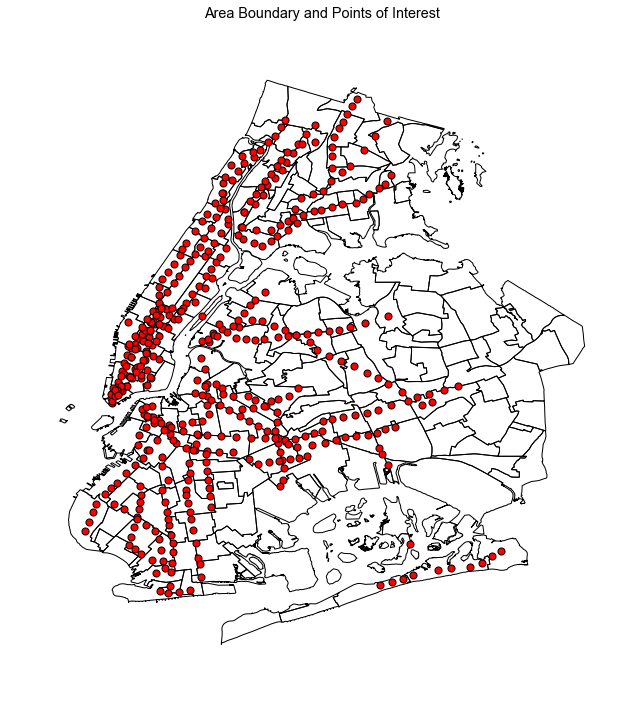

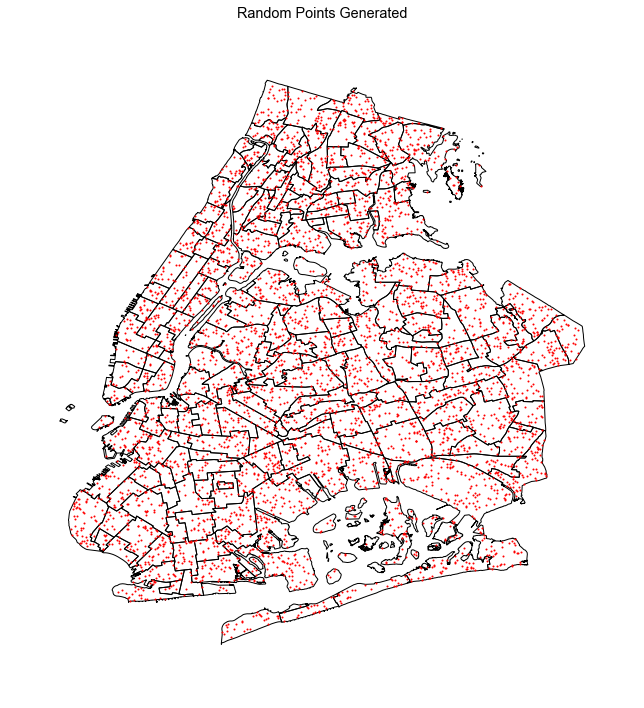

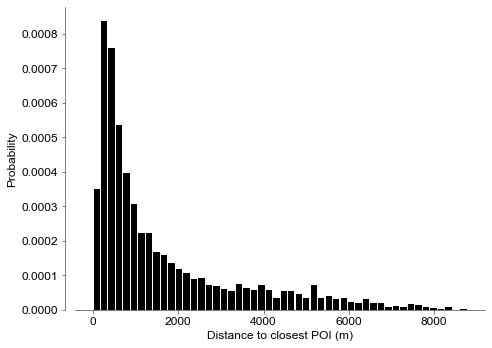

<Figure size 432x288 with 0 Axes>

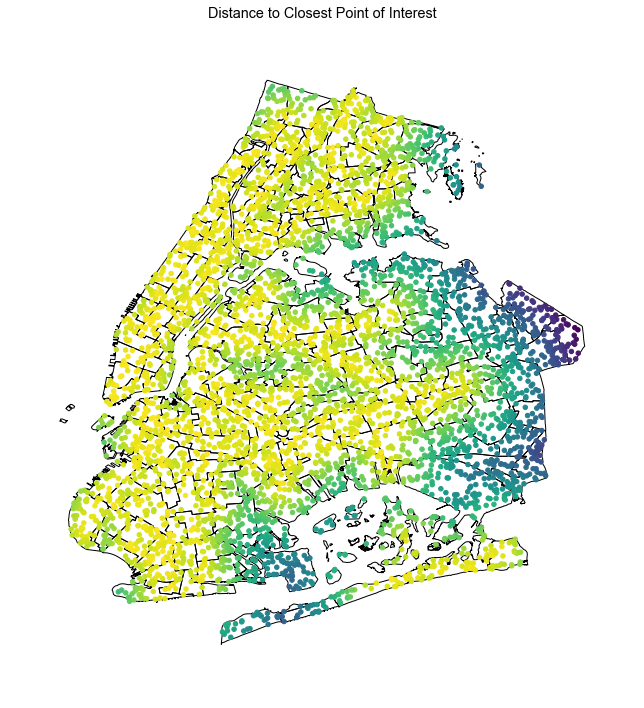

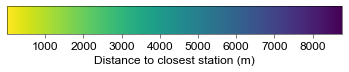

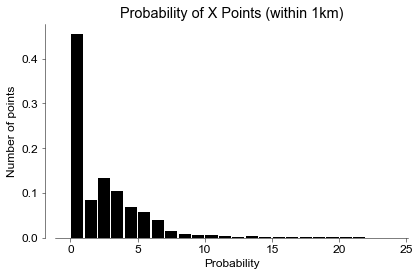

<Figure size 432x288 with 0 Axes>

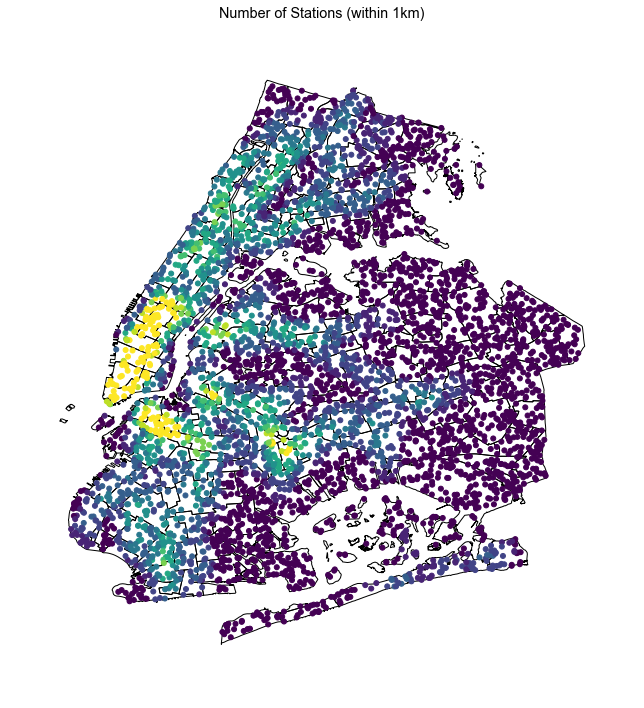

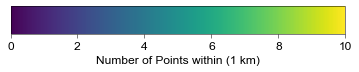

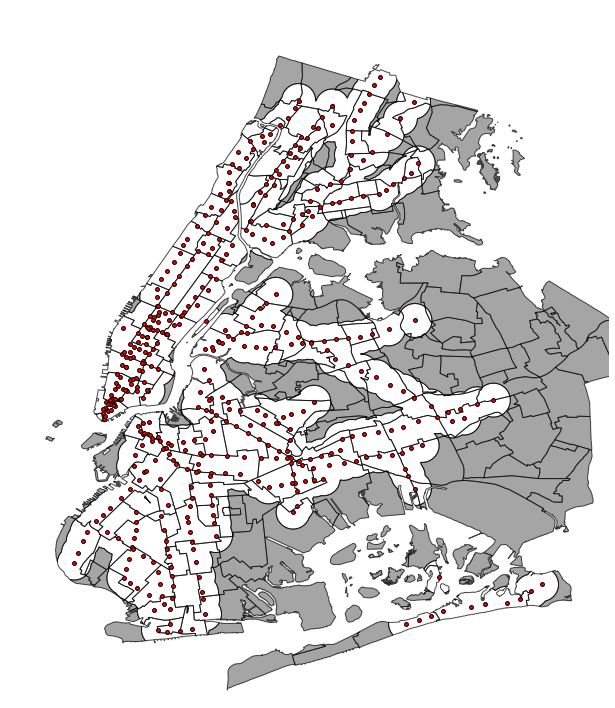

In [12]:
nyc_distances, nyc_n_points, nyc_area_covered, nyc_random = min_distance_random(nyc, nyc_stations, 5000, 'nyc')

# Paris

In [13]:
paris = geopandas.read_file('C:/Users/Zaca/Documents/Datasets/metro/paris/paris.shp').to_crs(epsg=4326)

# clean metro data
metro_raw = pd.read_json('C:/Users/Zaca/Documents/Datasets/metro/paris/paris_subway.geojson')
metro = json_normalize(metro_raw['features'])

# take only multipoints
# there are still more stations than what wikipedia says.
paris_stations = metro.loc[metro['geometry.type'] == 'MultiPoint', 'geometry.coordinates']
paris_stations = [x[0] for x in paris_stations if len(x) == 1]
paris_stations = [Point(x, y) for x, y in paris_stations]

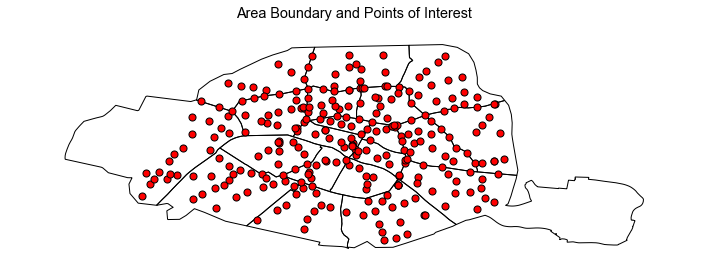

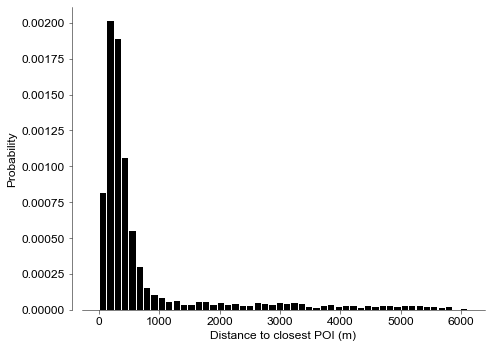

<Figure size 432x288 with 0 Axes>

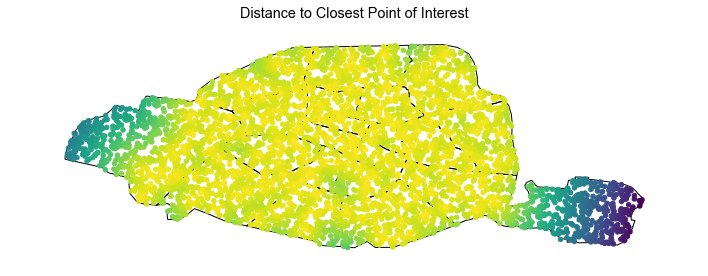

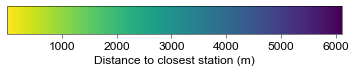

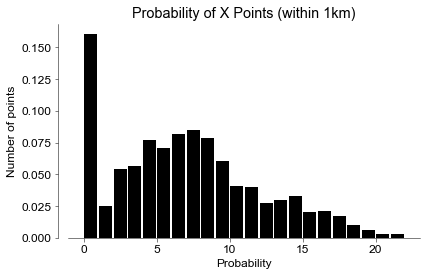

<Figure size 432x288 with 0 Axes>

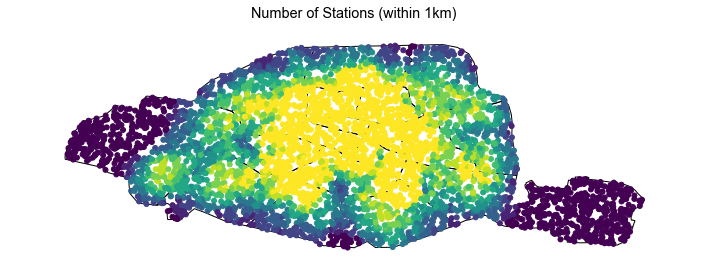

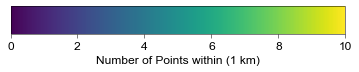

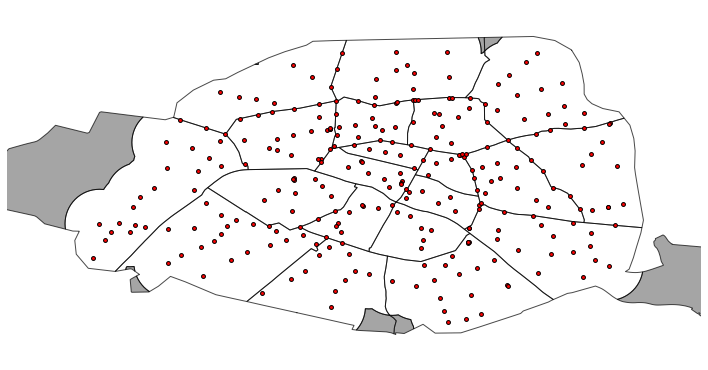

In [14]:
paris_distances, paris_n_points, paris_area_covered, paris_random = min_distance_random(paris, paris_stations, 5000, 'paris')

# Moscow

In [15]:
# get map
moscow = geopandas.read_file('C:/Users/Zaca/Documents/Datasets/metro/moscow/moscow.shp').to_crs(epsg=4326)
moscow = moscow[moscow['NAME_1'] == 'Moscow City']
moscow = moscow[moscow['NAME_2'] != 'Zelenogradsky']

# scrape locations from wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations'
soup = response_and_soup(url)

location_text = [t.text for t in soup.find_all('span', {'class':'geo-dec'})]

location_text = [s.replace('°', '').replace('N', '').replace('E', '').split(' ') for s in location_text]

latlong = []
for s in location_text:
    latlong += [[float(x) for x in s]]
    
moscow_stations = [Point(x, y) for y, x in latlong]

Response code: 200


### Moscow Data Ready

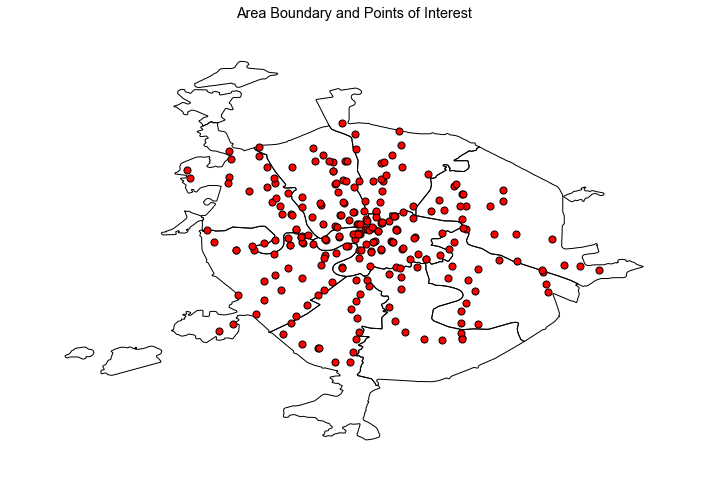

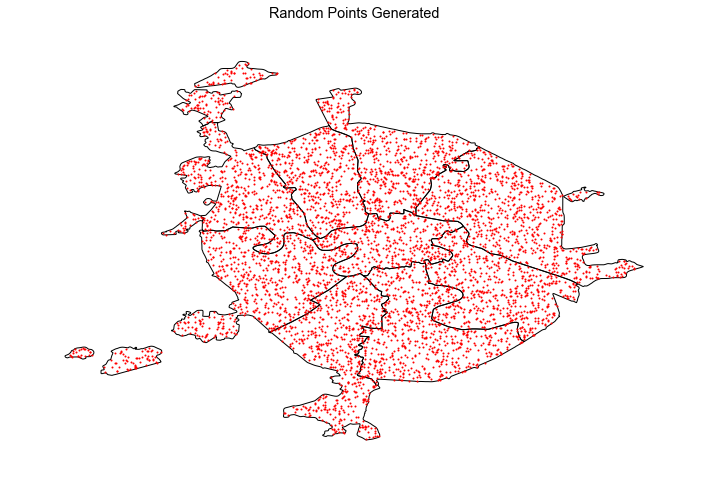

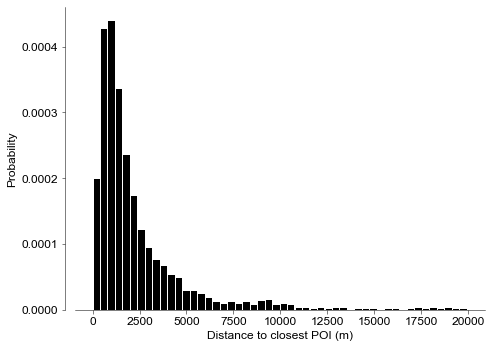

<Figure size 432x288 with 0 Axes>

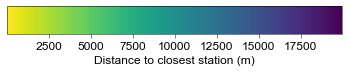

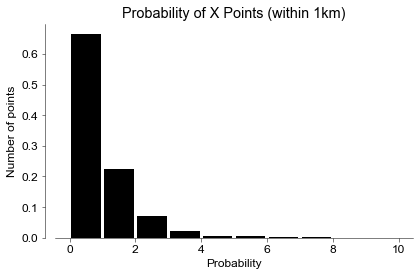

<Figure size 432x288 with 0 Axes>

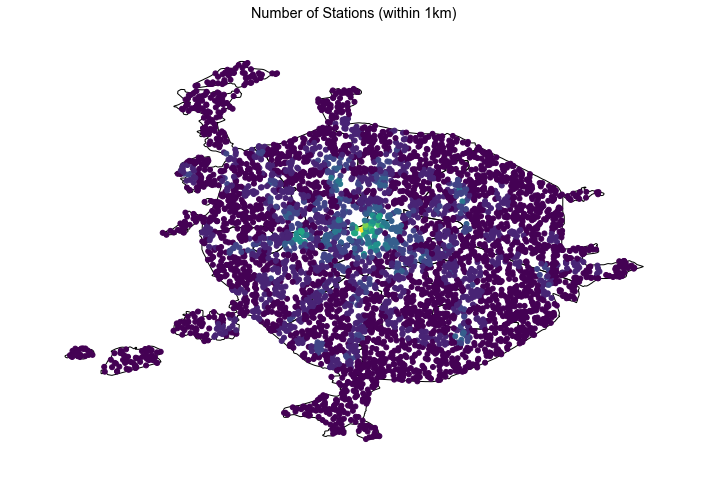

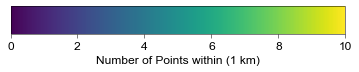

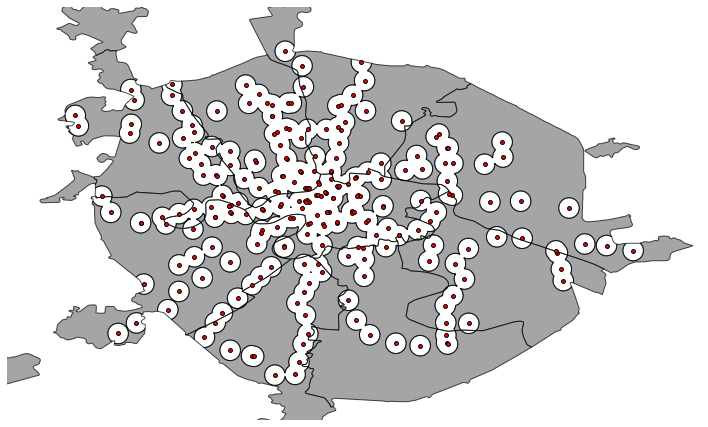

In [16]:
moscow_distances, moscow_n_points, moscow_area_covered, moscow_random = min_distance_random(moscow, moscow_stations, 5000, 'moscow')

# London

In [17]:
# opening london geometry
london = geopandas.read_file('C:/Users/Zaca/Documents/Datasets/metro/london/london.shp').to_crs(epsg=4326)
london = london[london['Designated'] == 'Inner']

# opening underground station location
london_location = 'C:/Users/Zaca/Documents/Datasets/metro/london/stations.kml'

# parse xml file with beautifulsoup
with open(london_location) as f:
    soup = BeautifulSoup(f, 'xml')
    
coordinates = [t.text for t in soup.find_all('coordinates')]

stations = [s.replace('\n', '').replace('\t', '').replace(',0', '').split(',') for s in coordinates]

station_float = []
for station in stations:
    station_float += [[float(x) for x in station]]
    
london_stations = [Point(x, y) for x, y in station_float]

### London Data Ready

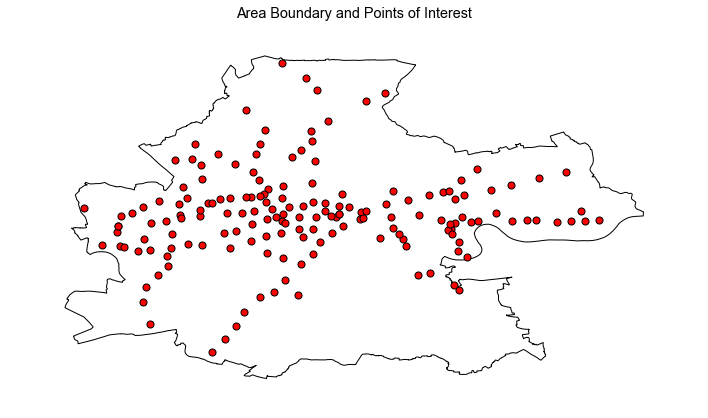

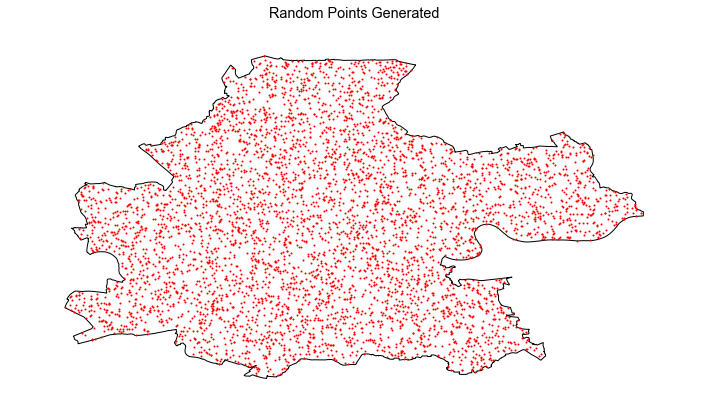

<Figure size 432x288 with 0 Axes>

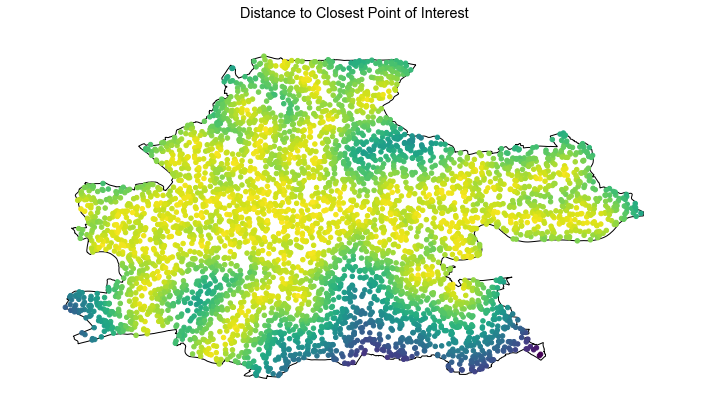

<Figure size 432x288 with 0 Axes>

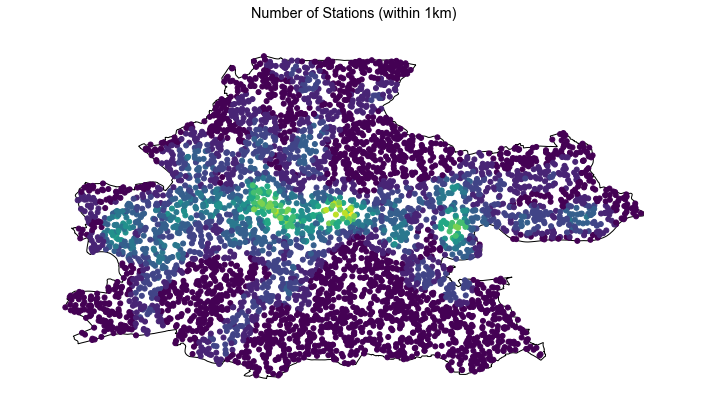

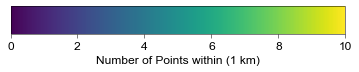

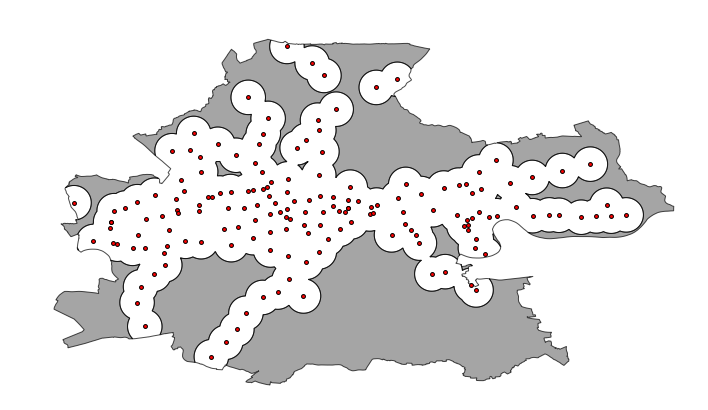

In [18]:
london_distances, london_n_points, london_area_covered, london_random = min_distance_random(london, london_stations, 5000, 'london')

# Statistical Analysis

### Average distance

In [19]:
# save minimum distance from random points to station
distances = [paris_distances, london_distances, lisbon_distances, nyc_distances, moscow_distances]

distances_means = [np.mean(x) for x in distances]
distances_ci = [stats.norm.interval(alpha=.99, loc=np.mean(x), scale=stats.sem(x)) for x in distances]

cities = ['Paris', 'London', 'Lisbon', 'NYC', 'Moscow']

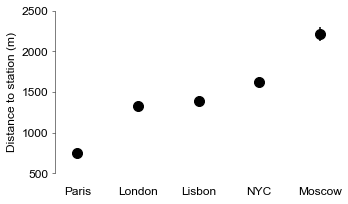

In [20]:
# make plot
fig, ax = plt.subplots(figsize=(5, 3))
ax = default_plot(ax, ['left', 'bottom'])

for i in range(len(distances)):
    ax.vlines(i, distances_ci[i][0], distances_ci[i][1], 'k')
    ax.scatter(i, distances_means[i], s=100, c='k')

ax.spines["bottom"].set_visible(False)
ax.set_xticks(range(len(distances)))
ax.set_xticklabels(cities)
ax.tick_params(axis='x',length=0)
plt.ylim(500, 2500)
plt.ylabel('Distance to station (m)')
plt.tight_layout()
plt.savefig('figures/average_distance_all_cities.png')

In [21]:
# test differences with ANOVA
anova = stats.f_oneway(lisbon_distances, nyc_distances, paris_distances, london_distances, moscow_distances)

# test closest groups with t-test
london_lisb = stats.ttest_ind(lisbon_distances, london_distances)
lisb_nyc = stats.ttest_ind(lisbon_distances, nyc_distances)


### NYC Correlation with Population Density

In [22]:
# correlation with population density
point_count = []

for x in nyc['geometry']:    
    count = 0
    for point in nyc_stations:
        if point.within(x):
            count+=1
    point_count += [count]

nyc['nstations'] = point_count
nyc['popdty'] = nyc['popdty'].str.replace('NA', '0').astype('float')

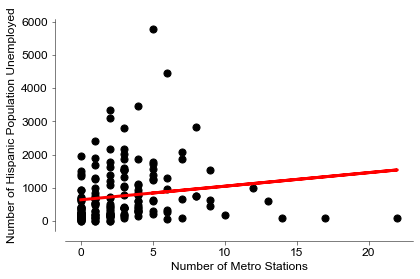

In [23]:
# correlation with hispanic unemployed
x = nyc['nstations']
y = nyc['hispanicun']

# make plot
fig, ax = plt.subplots()
ax = default_plot(ax, ['left', 'bottom'])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
plt.scatter(x, y, color= 'k', s=50)
plt.xlabel('Number of Metro Stations')
plt.ylabel('Number of Hispanic Population Unemployed')
plt.plot(x, x*slope + intercept, color= 'r', lw=3);
plt.tight_layout()
plt.savefig('figures/correlation_nyc.png')

# Area Covered

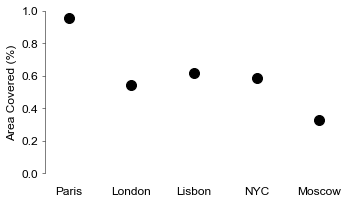

In [24]:
# percentage of area covered
area_covered = [paris_area_covered, london_area_covered, lisbon_area_covered, nyc_area_covered, moscow_area_covered]
area_covered = [x[0]/x[1] for x in area_covered]

fig, ax = plt.subplots(figsize=(5, 3))
ax = default_plot(ax, ['left', 'bottom'])

for i in range(len(distances)):
    ax.scatter(i, area_covered[i], s=100, c='k')

ax.spines["bottom"].set_visible(False)
ax.set_xticks(range(len(distances)))
ax.set_xticklabels(cities)
ax.tick_params(axis='x',length=0)
plt.ylim(0, 1)
plt.ylabel('Area Covered (%)')
plt.tight_layout()
plt.savefig('figures/area_covered_all_cities.png')

# Probability of at least 2

In [25]:
at_least_2 = len([x for x in lisbon_n_points if x >= 2])/len(lisbon_n_points)

In [26]:
n_points = [lisbon_n_points, nyc_n_points, paris_n_points, london_n_points, moscow_n_points]


In [27]:
# function to calculate at least 2 metro stations within 1km
def at_least_2(npoints):
    return len([x for x in npoints if x >= 2])

In [28]:
at_least2 = [at_least_2(x) for x in n_points]
probability = sorted([x/5000 for x in at_least2])

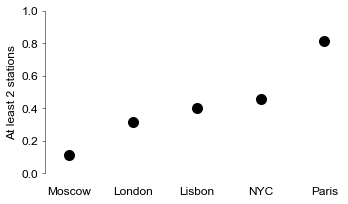

In [29]:
cities = ['Moscow', 'London', 'Lisbon', 'NYC', 'Paris']

fig, ax = plt.subplots(figsize=(5, 3))
ax = default_plot(ax, ['left', 'bottom'])

for i in range(len(distances)):
    ax.scatter(i, probability[i], s=100, c='k')

ax.spines["bottom"].set_visible(False)
ax.set_xticks(range(len(distances)))
ax.set_xticklabels(cities)
ax.tick_params(axis='x',length=0)
plt.ylim(0, 1)
plt.ylabel('At least 2 stations')
plt.tight_layout()
plt.savefig('figures/probability_of_2.png')

In [30]:
# quick test
lisbon2 = at_least2[0]
nyc2 = at_least2[1]
paris2 = at_least2[2]
london2 = at_least2[3]
moscow2 = at_least2[4]
proportions_ztest([london2, nyc2], [5000, 5000])

(-14.605794728554953, 2.5795656958621746e-48)

In [1]:
# geolocations scraped for padaria portuguesa
latitudes = ['38.760386','38.735307',
 '38.768881',
 '38.710867',
 '38.753493',
 '38.716133',
 '38.750588',
 '38.743516',
 '38.697388',
 '38.715553',
 '38.754560',
 '38.715987',
 '38.731546',
 '38.732075',
 '38.763426',
 '38.742140',
 '38.706629',
 '38.723316',
 '38.739036',
 '38.767709',
 '38.723638',
 '38.716962',
 '38.760391',
 '38.750645',
 '38.711496',
 '38.702392',
 '38.718155',
 '38.732881',
 '38.725981',
 '38.763073',
 '38.709875',
 '38.754745',
 '38.748843',
 '38.748498',
 '38.719933',
 '38.731012',
 '38.712975',
 '38.714839',
 '38.710692',
 '38.749078',
 '38.731820',
 '38.728123',
 '38.770604']

In [2]:
longitudes = ['-9.168566', '-9.144167', '-9.096086', '-9.143152', '-9.143284', '-9.166782', '-9.202032', '-9.146623', '-9.202651', '-9.149136', '-9.188615', '-9.141263', '-9.139988', '-9.151776', '-9.153311', '-9.135683', '-9.144185', '-9.150684', '-9.148713', '-9.157997', '-9.161568', '-9.157669', '-9.114580', '-9.172192', '-9.213148', '-9.180991', '-9.129759', '-9.130327', '-9.149290', '-9.180586', '-9.138150', '-9.095648', '-9.178337', '-9.190668', '-9.139986', '-9.134767', '-9.181618', '-9.136053', '-9.136725', '-9.137497', '-9.145735', '-9.142920', '-9.097991']

In [33]:
latitudes = [float(x) for x in latitudes]
longitudes = [float(x) for x in longitudes]
padarias = [Point(y, x) for x, y in list(zip(latitudes, longitudes))]

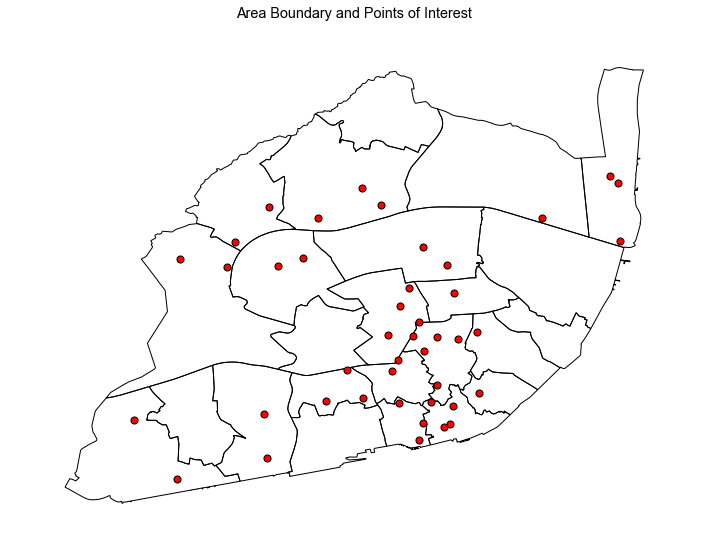

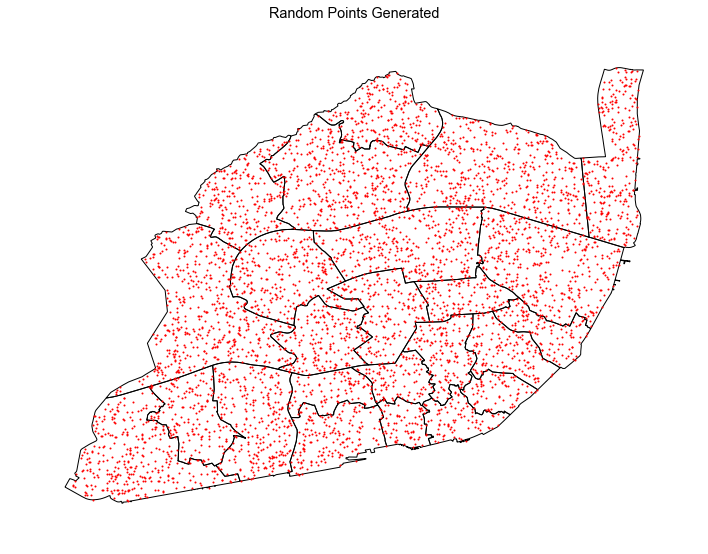

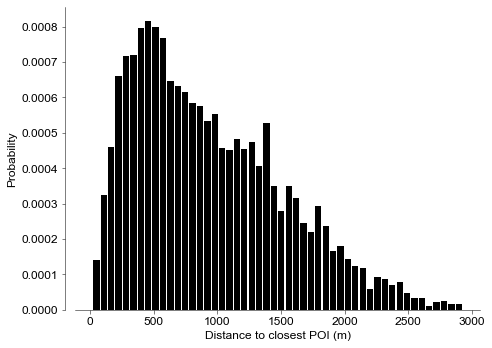

<Figure size 432x288 with 0 Axes>

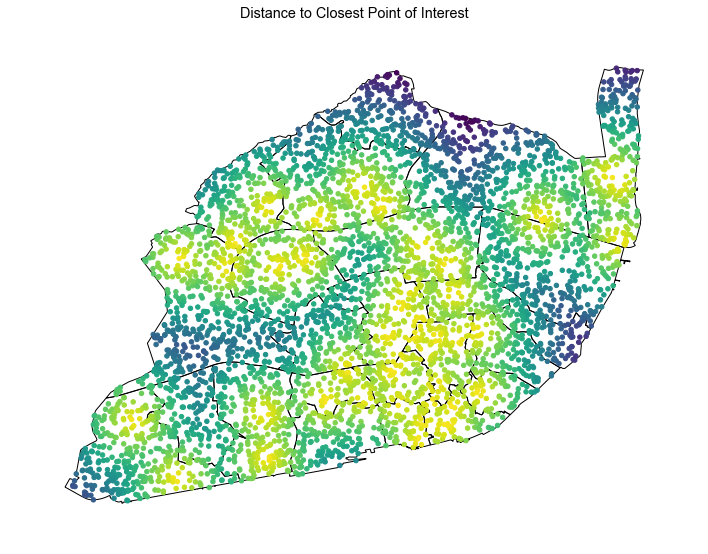

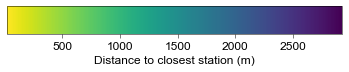

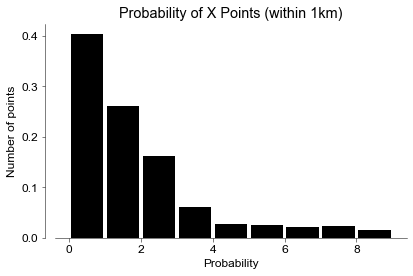

<Figure size 432x288 with 0 Axes>

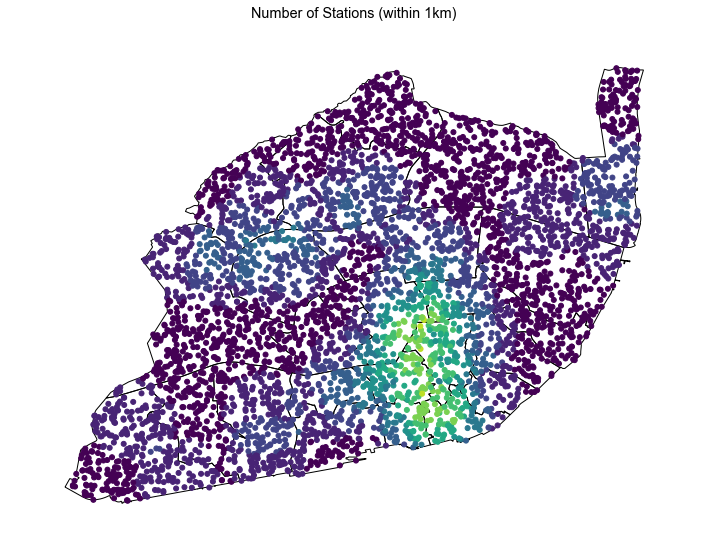

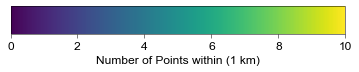

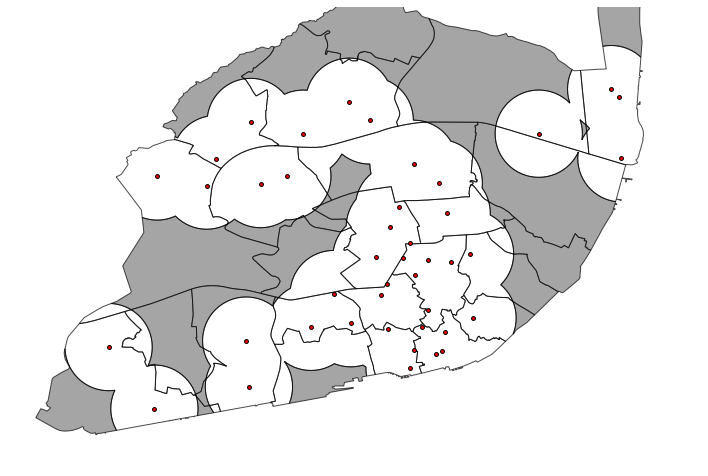

In [34]:
padaria_distances, padaria_n_points, padaria_area_covered, padaria_random = min_distance_random(lisbon, padarias, 5000, 'lisbon_padarias')

In [38]:
point_count = []

for x in lisbon['geometry']:    
    count = 0
    for point in padarias:
        if point.within(x):
            count+=1
    point_count += [count]

lisbon['padarias'] = point_count

In [39]:
lisbon['density'] = lisbon['Eleitores2']/lisbon['AREA_T_Ha']

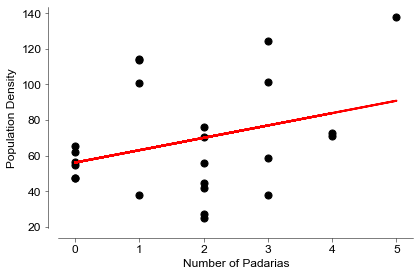

In [40]:
x = lisbon['padarias']
y = lisbon['density']

fig, ax = plt.subplots()
ax = default_plot(ax, ['left', 'bottom'])
plt.xlabel('Number of Padarias')
plt.ylabel('Population Density')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
plt.scatter(x, y, color= 'k', s=50)
plt.plot(x, x*slope + intercept, color= 'r', lw=2);
plt.tight_layout()
plt.savefig('figures/correlation_nyc.png')